In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Train: (20216100, 4) Weather: (139773, 9) Building: (1449, 6)
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2261
[LightGBM] [Info] Number of data points in the train set: 13481, number of used features: 28
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 7.551871
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[117]	training's rmse: 0.0750486	valid_1's rmse: 0.04781
✅ Updated Accuracy Results Table:
     Model           RMSE  R2_Score          MAE
0   Hourly  163837.377960  0.152751  2589.518941
1  Monthly   31105.041677  0.656182  1565.657548


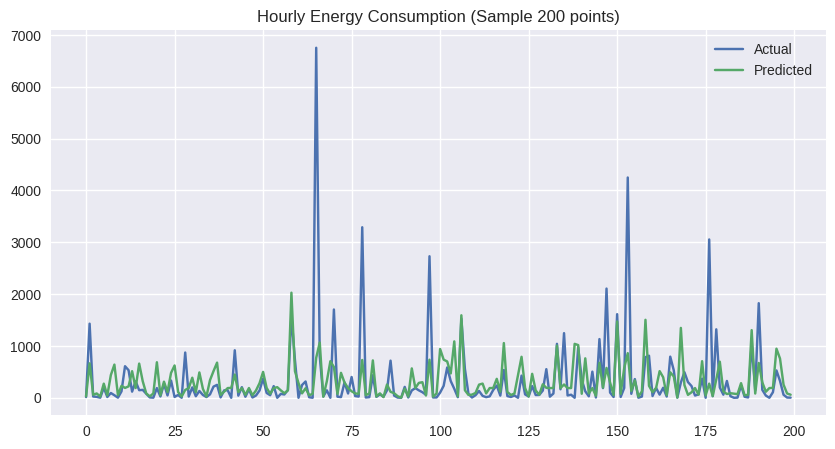

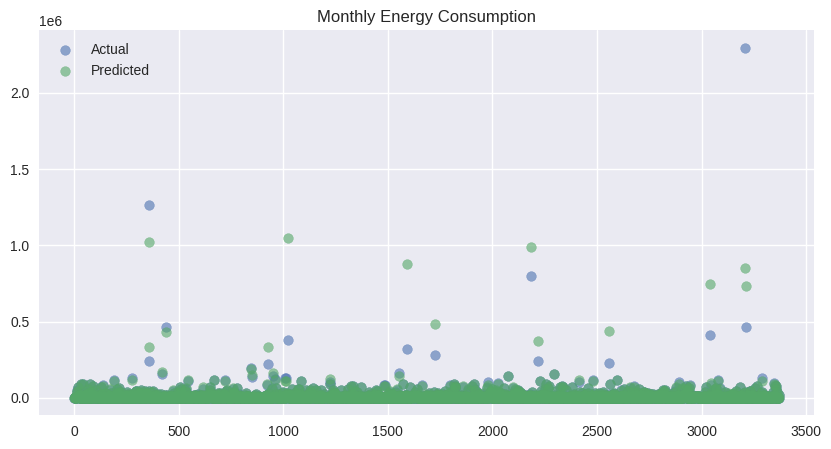

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pickle

plt.style.use('seaborn-v0_8')
base_path = '/content/drive/MyDrive/Energy_Prediction_Project/data/'

# ---------------- Load Data ----------------
train = pd.read_csv(base_path + 'train.csv')
weather = pd.read_csv(base_path + 'weather_train.csv')
building = pd.read_csv(base_path + 'building_metadata.csv')

print("Train:", train.shape, "Weather:", weather.shape, "Building:", building.shape)

# Merge datasets
df = train.merge(building, on='building_id', how='left')
df = df.merge(weather, on=['site_id', 'timestamp'], how='left')

# Sample 100k rows for RAM efficiency
df = df.sample(n=100000, random_state=42)

# ---------------- Feature Engineering ----------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day
df['month'] = df['timestamp'].dt.month
df['dayofweek'] = df['timestamp'].dt.dayofweek

# Handle missing numeric values
df.fillna(df.mean(numeric_only=True), inplace=True)

# Encode primary_use
df = pd.get_dummies(df, columns=['primary_use'])

# ---------------- Hourly Model ----------------
X_hour = df[['square_feet', 'air_temperature', 'dew_temperature', 'hour', 'dayofweek', 'month']]
y_hour = df['meter_reading']

X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(X_hour, y_hour, test_size=0.2, random_state=42)

rf_hour = RandomForestRegressor(n_estimators=20, max_depth=10, random_state=42, n_jobs=-1)
rf_hour.fit(X_train_h, y_train_h)

preds_hour = rf_hour.predict(X_test_h)

# ---------------- Monthly Model with Aggregated Features ----------------
# Aggregate hourly stats per building per month
agg_funcs = ['mean', 'max', 'min', 'std']
monthly_stats = df.groupby(['building_id','month'])['meter_reading'].agg(agg_funcs).reset_index()
monthly_stats.columns = ['building_id','month','mean_reading','max_reading','min_reading','std_reading']

# Merge with building metadata
monthly = monthly_stats.merge(building, on='building_id', how='left')

# Aggregate weather stats per site per month
weather['timestamp'] = pd.to_datetime(weather['timestamp'])
weather['month'] = weather['timestamp'].dt.month
weather_monthly = weather.groupby(['site_id','month']).mean(numeric_only=True).reset_index()

monthly = monthly.merge(weather_monthly, on=['site_id','month'], how='left')

# Encode primary_use
monthly = pd.get_dummies(monthly, columns=['primary_use'])

# Select features
weather_features = ['air_temperature','dew_temperature','cloud_coverage','precip_depth_1_hr','sea_level_pressure','wind_speed']
primary_use_cols = [col for col in monthly.columns if col.startswith('primary_use_')]
agg_features = ['mean_reading','max_reading','min_reading','std_reading']
X_month = monthly[['square_feet','month'] + agg_features + primary_use_cols + weather_features]
y_month = monthly['mean_reading'] * 30  # approximate monthly energy from mean hourly

# Log-transform target
y_month_log = np.log1p(y_month)

# Train-test split
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X_month, y_month_log, test_size=0.2, random_state=42)

# LightGBM dataset
lgb_train = lgb.Dataset(X_train_m, label=y_train_m)
lgb_eval = lgb.Dataset(X_test_m, label=y_test_m, reference=lgb_train)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Early stopping callback
early_stopping_callback = early_stopping(stopping_rounds=50, verbose=True)

# Train LightGBM model
lgb_model = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    num_boost_round=1000,
    callbacks=[early_stopping_callback]
)

# Predictions (inverse log)
preds_month_log = lgb_model.predict(X_test_m, num_iteration=lgb_model.best_iteration)
preds_month = np.expm1(preds_month_log)

# ---------------- Accuracy Results Table ----------------
metrics = {
    'Model': ['Hourly', 'Monthly'],
    'RMSE': [np.sqrt(mean_squared_error(y_test_h, preds_hour)),
             np.sqrt(mean_squared_error(np.expm1(y_test_m), preds_month))],
    'R2_Score': [r2_score(y_test_h, preds_hour),
                 r2_score(np.expm1(y_test_m), preds_month)],
    'MAE': [mean_absolute_error(y_test_h, preds_hour),
            mean_absolute_error(np.expm1(y_test_m), preds_month)]
}

results_df = pd.DataFrame(metrics)
print("✅ Updated Accuracy Results Table:")
print(results_df)

# ---------------- Plots ----------------
plt.figure(figsize=(10,5))
plt.plot(y_test_h.values[:200], label='Actual')
plt.plot(preds_hour[:200], label='Predicted')
plt.title('Hourly Energy Consumption (Sample 200 points)')
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(range(len(np.expm1(y_test_m))), np.expm1(y_test_m), label='Actual', alpha=0.6)
plt.scatter(range(len(preds_month)), preds_month, label='Predicted', alpha=0.6)
plt.title('Monthly Energy Consumption')
plt.legend()
plt.show()

# ---------------- Save Models ----------------




In [4]:
import pickle

pickle.dump(rf_hour, open('/content/drive/MyDrive/Energy_Prediction_Project/models/rf_hour.pkl','wb'))
pickle.dump(lgb_model, open('/content/drive/MyDrive/Energy_Prediction_Project/models/lgb_month.pkl','wb'))
print("✅ Models saved successfully")


✅ Models saved successfully
